In [1]:
# idea and layout code by Eric Mattson,  M630 Spring 2024
import networkx as nx
import numpy as np

import holoviews as hv; hv.extension('matplotlib', logo=False)
import panel as pn;     pn.extension('katex', 'mathjax')

from IPython.display import Markdown, display
def _pr( txt, color='blue',sz=20,ht=25): return f'<strong style="font-size:{sz}px;height:{ht}px;color:{color};">{txt}</strong>'
def pr( txt, color='blue',sz=20,ht=25):  display(Markdown(f'<strong style="font-size:{sz}px;height:{ht}px;color:{color};">{txt}</strong>'))

import matplotlib.pyplot as plt
from matplotlib.figure import Figure   # <- necessary to use panel!

def draw_nxgraph(G, pos, figsize=(4,3), options=None):
    if options is None:
        options = {
            'node_color': 'lightgreen',
            'node_size': 200,
            'width': 1,
            'font_weight': 'bold',
        }
    fig  = Figure(figsize=figsize)
    ax   = fig.subplots()
    #pos  = None if layout is None else layout(G)
    nx.draw(G, pos=pos, with_labels=True, **options, ax=ax)
    return fig
def format_matrix(matrix, environment="pmatrix", formatter=str, col_partition=None, row_partition = None):
    """Format a matrix using LaTeX syntax"""
    if col_partition is not None:
        environment="array"
        if isinstance( col_partition, int): col_partition=[col_partition]
    if row_partition is not None:
        if isinstance( row_partition, int): row_partition=[row_partition]

    if not isinstance(matrix, np.ndarray):
        try:
            matrix = np.array(matrix)
        except Exception:
            raise TypeError("Could not convert to Numpy array")

    if len(shape := matrix.shape) == 1:
        matrix = matrix.reshape(1, shape[0])
    elif len(shape) > 2:
        raise ValueError("Array must be 2 dimensional")

    body_lines = [" & ".join(map(formatter, row)) for row in matrix]
    if environment == "array":
        if col_partition is None:
            fmt = str(matrix.shape[1]*'r')
        else:
            diff = [col_partition[i]-col_partition[i-1] for i in range(1,len(col_partition))]
            fmt = "|".join([str(col_partition[0]*"r")]+
                  [k*"r" for k in diff] +
                  [str((matrix.shape[1]-col_partition[-1])*"r")])
    if row_partition is None:
        body = "\\\\".join(body_lines)
    else:
        num = len(row_partition)
        diff = [row_partition[i]-row_partition[i-1] for i in range(1,num)]
        mid  = [body_lines[row_partition[k-1]:row_partition[k]] for k in range(1,num) ]
        if not mid:
            body = " \\\\ \\hline ".join([ body_lines[0:row_partition[0]][0],
                   body_lines[row_partition[-1]:][0]
            ])
        else:
            body = " \\\\ \\hline ".join([ body_lines[0:row_partition[0]][0],
                   mid,
                   body_lines[row_partition[-1]:][0]
            ])

    if environment=='array':
        txt = r'\left(\begin{array}{'+ fmt +'}'+body+r'\end{array}\right)'
    else:
        txt = f"""\\begin{{{environment}}}
{body}
\\end{{{environment}}}"""
    return txt

<div style="float:center;width:100%;text-align:center;">
<strong style="height:100px;color:darkred;font-size:40px;">The Adjacency Matrix</strong><br>
<strong style="height:45px;color:darkred;font-size:30px;">Matrix Multiplication Example</strong>
</div>

# 1. Graphs and Adjacency Matrices

## 1.1 Definitions

A **graph** consists of **nodes** connected by **edges**.<br>The following example shows a graph of 5 nodes labeled 1 .. 5
connected by 5 edges:

<strong style="font-size:20px;height:25px;color:blue;"><p>A Graph and its adjacency matrix representation</p></strong>

Row
    [0] Matplotlib(Figure, dpi=96, height=200)
    [1] Column
        [0] Spacer(height=50)
        [1] LaTeX(str)
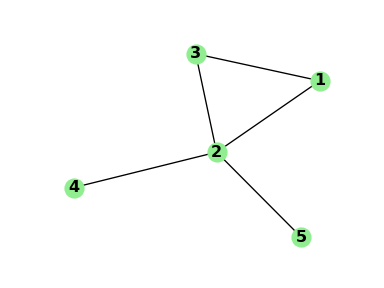

In [2]:
G = nx.Graph()
G.add_nodes_from(range(1,6))
G.add_edges_from([(1,2), (1,3), (2,3), (2,4), (2,5)])
A = nx.adjacency_matrix(G)
pr("<p>A Graph and its adjacency matrix representation</p>")
#pr("<p>Vertices {5,2,1,3,2} form a path", color="black", sz=18)
pn.Row( pn.pane.Matplotlib( draw_nxgraph(G,pos=nx.kamada_kawai_layout(G)), dpi=96,  height=200),
        pn.Column(pn.Spacer(height=50),
        pn.pane.LaTeX( 'Adjacency Matrix $A(G) = '+format_matrix(A.toarray())+'$' )))

<div style="background-color:#F2F5A9;color:black;">

**Definition:** The **adjacency matrix** of a graph<br>
$\qquad$ is an $n \times n$ matrix whose $(i,j)^{th}$ entry is given by<br><br>
$\qquad
A_{i j} = \left\{ \begin{align}
& 1, \qquad & \text{ if node }\; v_i\; \text{ is connected to node }\; v_j \\
& 0,        & \text{ otherwise}
\end{align}\right.
$
</div>

In the example the third row of the matrix shows that node 3 is connected to node 1 and node 2.

## 1.2 Multiplication by a Row Vector from the Left

### 1.2.1 Pick a Row of A

Consider the column vector $e_i = \begin{pmatrix} 0 \\ \vdots \\ 0 \\ \color{red}1 \\ 0 \\ \vdots \\ 0 \end{pmatrix}$,
$\quad$ the vector of all zeros except for the $i^{th}$ entry, which is equal to 1.<br><br>
* $e_i^t A\;$ returns **the ${i^{th}}$ row of $A$,** i.e., the vector of all nodes that can be reached starting from $i$
* $A e_i\;$ returns **the ${i^{th}}$ row of $A$,** i.e., the vector of all nodes with edges ending at node $i$

In [3]:
def vec_i(i, n):
    # construct column vector e_i of length n
    ei = np.zeros((n,1), dtype=int)
    ei[i,0] = 1
    return ei

A = A.todense()
v0 = vec_i(3,5)
v1= v0.T @ A

Consider multiplying the adjacency matrix $A$ from the the left by the vector $(\ 0\ 0\ 1\ 0\ 0\ )$ (i.e., a vector encoding the third node)

$\begin{pmatrix} 0 & 0 & 1 & 0 & 0\end{pmatrix}
\begin{pmatrix} 0 & 1 & 1 & 0 & 0 \\ 1 & 0 & 1 & 1 & 1 \\ \hline 1 & 1 & 0 & 0 & 0 \\ \hline 0 & 1 & 0 & 0 & 0 \\  0 & 1 & 0 & 0 & 0 \end{pmatrix} = \begin{pmatrix} 1 & 1 & 0 & 0 & 0  \end{pmatrix}
$

The result shows all vertices accessible from node 3: nodes 1 and 2 are both connected to node 3.

### 1.2.2 Sum two Rows of A

Consider multiplying the adjacency matrix $A$ from the the left by the vector $(\ 0\ 0\ 1\ 1\ 0\ )$ (i.e., a vector encoding the third and fourth nodes)

$\begin{pmatrix} 0 & 0 & 1 & 1 & 0\end{pmatrix}
\begin{pmatrix} 0 & 1 & 1 & 0 & 0 \\ 1 & 0 & 1 & 1 & 1 \\ \hline 1 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ \hline  0 & 1 & 0 & 0 & 0 \end{pmatrix} = \begin{pmatrix} 1 & 2 & 0 & 0 & 0  \end{pmatrix}
$

The result shows all vertices accessible from nodes 3 or 4:
* node 3 connects to both node 1 and node 2
* node 4 connects to node 2

Given the starting nodes 3 and 4, there is one way to connect to node 1, and there are two ways to connect to node 2.

### 1.2.3 Pick a Row and Multiply by $A$ Twice

What if we keep going? Take the vector $(\ 0\ 0\ 1\ 0\ 0\ )$ (i.e., a vector encoding the third node),
* multiply it by $A$ from the right, yielding all nodes connected to the third node
* take the result and again multiply by $A$ from the right, resulting in all nodes accessible from the previous step

The overall result is the set of nodes accessible from the original third node in 2 steps!<br>
The integer value is the number of different paths from node to node to node we can take fro the starting node to the ending node.

* $v_0 = \begin{pmatrix} 0 & 0 & 1 & 0 & 0\end{pmatrix}\quad$  (start from node 3)<br><br>
* $v_1 = v_0 A = \begin{pmatrix} 0 & 0 & 1 & 0 & 0\end{pmatrix}
\begin{pmatrix} 0 & 1 & 1 & 0 & 0 \\ 1 & 0 & 1 & 1 & 1 \\ 1 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\  0 & 1 & 0 & 0 & 0 \end{pmatrix}
$<br><br>
$v_1 = \begin{pmatrix} 1 & 1 & 0 & 0 & 0  \end{pmatrix}\quad$ (the nodes accessible from node 3 in one step)<br><br>
* $v_2 = v_1 A = v_0 A^2 = \begin{pmatrix} 1 & 1 & 0 & 0 & 0 \end{pmatrix} \begin{pmatrix} 0 & 1 & 1 & 0 & 0 \\ 1 & 0 & 1 & 1 & 1 \\ 1 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\  0 & 1 & 0 & 0 & 0 \end{pmatrix}$<br><br>
$v_2 = \begin{pmatrix} 1 & 1 & 2 & 1 & 1 \end{pmatrix}\quad$ (the nodes accessible from node 3 in two steps)


Row
    [0] Matplotlib(Figure, dpi=96, height=200)
    [1] Markdown(str)
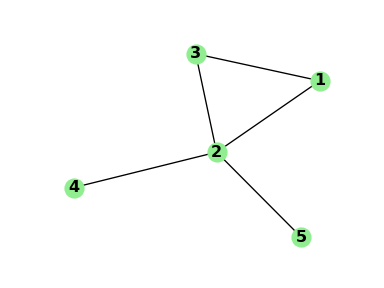

In [4]:
pn.Row( pn.pane.Matplotlib( draw_nxgraph(G,pos=nx.kamada_kawai_layout(G)), dpi=96,  height=200),
      pn.pane.Markdown(r"""
      Paths of length 2 starting from node 3 are counted by v₂

      * 3 -> 2 -> 1
      * 3 -> 1 -> 2
      * 3 -> 1 -> 3, &emsp; 3 -> 2 -> 3
      * 3 -> 2 -> 4
      * 3 -> 2 -> 5
      """))

In [7]:
#check the computation
v1 = v0.T @ A
v2 = v1 @ A
print(v2)

[[1 0 1 1 1]]


## 1.3 Powers of A

Consider the product $A^2 = A A$

$\qquad A^2 =
\left(\begin{array}{ccccc}
0 & 1 & 1 & 0 & 0\\1 & 0 & 1 & 1 & 1\\1 & 1 & 0 & 0 & 0\\
\hline 0 & 1 & 0 & 0 & 0\\ \hline
0 & 1 & 0 & 0 & 0
\end{array}\right)
\left(\begin{array}{ccccc}
0 & 1 & 1 & 0 & 0\\1 & 0 & 1 & 1 & 1\\1 & 1 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0
\end{array}\right) =
\left(\begin{array}{ccccc}
2 & 1 & 1 & 1 & 1\\1 & 4 & 1 & 0 & 0\\1 & 1 & 2 & 1 & 1\\
\hline 1 & 0 & 1 & 1 & 1\\ \hline
1 & 0 & 1 & 1 & 1
\end{array}\right)
$

* Look at entry $(4,k)$ in the matrix $A^2$, $k=1,2,\dots 5$: it yields row 2 of the $A$ matrix on the right,<br> i.e., all nodes accessible from node 2 (as specified by the third row of the $A$ matrix on the left
* Similarly, look at $(1,k)$ in the matrix $A^2$, $k=1,2,\dots 5$: it yields the sum of row 2  and row 3 of the $A$ matrix on the right,<br> i.e., all nodes accessible from either node 2 or node 3 (as specified by the first row of the $A$ matrix on the left

This generalizes: **the entry $(i,j)$ of $A^n$ computes the number of paths from any starting node $i$ to any ending node $j$.**

____
**Remark:** using the column vector $e_i$ defined previously
* $e_i^t A^n\;$ returns **the vector of ending nodes** of a path of length $n$ starting at node $i\;$ (the $i^{th}$ row of $A^n$)
* $A^n e_i\;$ returns **the vector of starting nodes** of a path of length $n$ ending at node $i\;$ (the $i^{th}$ column of $A^n$)

# 2. Counting Triangles

Consider the following graph. How many triangles are there?<br>
**Assume any nodes on the same line are connected** (e.g., node 0 is connected to node 5)

Row
    [0] Matplotlib(Figure, dpi=200, height=400)
    [1] Column
        [0] Spacer(height=50)
        [1] LaTeX(str, styles={'font-size': '10pt'})
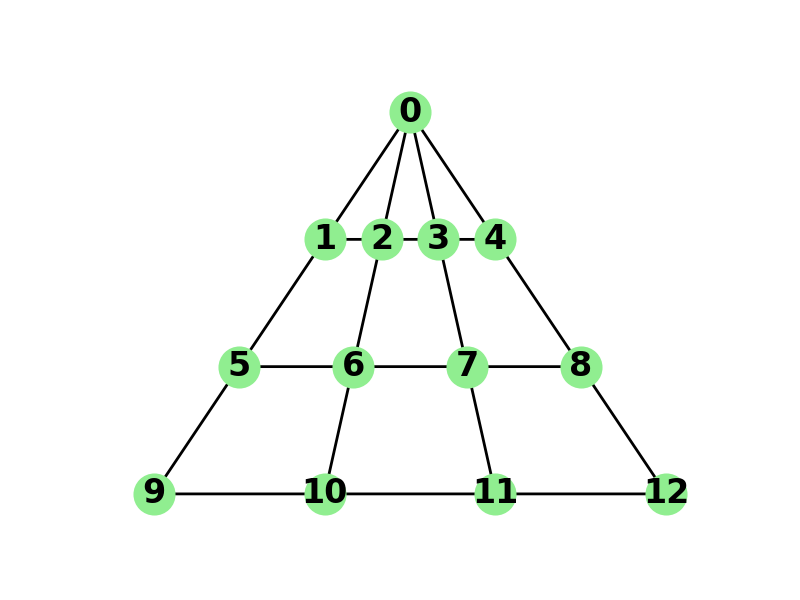

In [8]:
A = np.zeros((13,13), dtype=int) # A is the adjacancy matrix
A[0,1:] = 1
A[1:,0] = 1
for i in range(1,10,4):
    for j in range(1,10,4):
        if i == j:
            A[i:i+4,j:j+4] = np.ones((4,4), dtype=int) - np.eye(4, dtype=int)
        else:
            A[i:i+4,j:j+4] = np.eye(4, dtype=int)

N = np.zeros((13,13), dtype=int) # N is displayed graph (lines would pass over nodes otherwise)
N[0,1:5] = 1
for i in range(1,12):
    if i<9:
        N[i,i+4] = 1
    if i%4 != 0:
        N[i,i+1] = 1

G = nx.from_numpy_array(N, create_using=nx.MultiGraph, parallel_edges=True)
p = {0:(0,3),
    1 :(-1/2,2), 2 :(-1/6,2), 3 :(1/6,2), 4 :(1/2,2),
    5 :(-1,1), 6 :(-1/3,1), 7 :(1/3,1), 8 :(1,1),
    9 :(-3/2,0), 10:(-1/2,0), 11:(1/2,0), 12:(3/2,0)}

pn.Row( pn.pane.Matplotlib( draw_nxgraph(G, pos=p), dpi=200,  height=400),
        pn.Column(pn.Spacer(height=50),
        pn.pane.LaTeX( '$A = '+format_matrix(A)+'$' , styles={'font-size': '10pt'})))

A triangle has path length 3. Given three nodes (a, b, c), the path consists of a->b->c->a,<br>
i.e., we are interested in the paths starting and ending at the same node: the entries $(i,i)$ in $A^3$, where $A$ is the adjacency matrix.

**Remarks**:
* We can start start from any vertex in a triangle:<br>
the paths a->b->c->a, b->c->a->b and c->a->b->c are the same triangle
* We can traverse a triangle in opposite orientations:<br>
the paths a->b->c->a and a->c->b->a represent the same triangle
* there are degenerate triangles on every line: e.g. 1->2->3->1

**Thus the entry $(i,i)$ of $A^3$ counts each triangle 6 times!**

**The total number of triangles (including degenerate triangles)** is given by<br>
$\qquad N = \sum_{i=0}^{12} {A^3_{i i}},\;$ the sum of the diagonal entries of $A^3$, i.e.,  the **trace** of $A^3$.

In [9]:
# Remark the sum of the diagonal entries of a matrix is known as the trace
print( "There are ", np.trace(A@A@A)//6, "triangles (including degenerate triangles) in the figure")

There are  46 triangles (including degenerate triangles) in the figure


Since each of the 7 straight lines in the figure has ${}_4C_3 = 4$ degenerate triangles,<br>
we arrive at a total count of $46-4 \times 7 = 18$ non degenerate triangles.

# 3. Take Away

Linear Algebra concepts applied to matrices associated with graphs lead to useful results.<br>
we were able to interpret matrix multiplication in terms of graph concepts by partitioning the matrices.

In particular, we have encountered the following useful concepts:
* vector/matrix and matrix/matrix multiplication
* powers of matrices
* the trace of a matrix
